In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
# 显示图像
def img_show(img):
    if len(img.shape) == 3:
        if img.shape[-1]==3:
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
        elif img.shape[-1]==4:
            b,g,r,a = cv2.split(img)
            img = img
        plt.imshow(img)
    elif len(img.shape) == 2:
        plt.imshow(img)

In [3]:
# 随机加椒盐函数
def salt(img,n):
    # 循环添加n个椒盐
    for k in range(n):
        # 随机添加椒盐的坐标
        i = int(np.random.random()*img.shape[0])
        j = int(np.random.random()*img.shape[1])
        # 若位灰度图
        img[i,j] = 255
        # 若为RGB图
        img[i,j,0] = 255
        img[i,j,0] = 255
        img[i,j,0] = 255
    return img

# 10.1 Canny边缘检测基础

In [6]:
# Canny边缘检测分为如下几步：
# 1.去噪
# 2.计算梯度的幅度和方向
# 3.非极大抑制，即适当地让边缘变瘦
# 4.确定边缘。使用双阈值算法确定最终的边缘信息

# 1.应用高斯滤波去除图像噪声
# 高斯滤波器对周围像素计算计算加权平均值，越邻近中心点，权值越大，滤波器大小可变，高斯核的大小对边缘检测效果具有很重要的作用，
# 核越大，边缘信息对噪声的敏感度就越低，不过核越大，边缘检测的定位错误也会增加，通常5*5能满足大多数情况

# 2.计算梯度
# 边缘检测算子返回水平方向的Gx和垂直方向的Gy。梯度的幅度G和方向𝚯（用角度值表示）为：
# G = (√G^2x + G^2y)
# 𝚯 = atan2(Gy,Gx)
# 式中，atan2(.)表示具有两个参数的arctan函数
# 梯度的方向总是与边缘垂直的，通常就近取之为水平（左，右）、垂直（上，下）、对角线（右上，左上，左下，右下）等8个不同方向
# 因此，在计算梯度时，我们会得到梯度的幅度和角度（代表梯度的方向）两个值
# 如图，其中值2↑表示一个二元数对（2，90），2表示梯度的幅度为2，角度为90度
# 2↑ 3↑ 2↑ 2↑ 5↑
# 3↑ 2↑ 9↑ 6↑ 2↑
# 4↑ 8↑ 6↑ 3↑ 3↑
# 7↑ 2↑ 2↑ 2→ 4➚
# 6↑ 2↑ 2← 1→ 2→

# 3.非极大值抑制
# 获得了梯度的幅度和方向后，遍历图像中的像素点，去除所有非边缘的点
# 具体实现时，逐一遍历像素点，判断当前像素点是否是周围像素点中具有相同梯度方向的最大值，根据判断结果决定是否抑制该点
# -如果该点是正/负梯度方向上的局部最大值，则保留该点
# -如果不是，则抑制该点（归零）
# 经过上述处理，对同一方向的若干边缘点，基本上仅保留一个，实现边缘细化的目的

# 4.应用双阈值确定边缘
# 完成上述操作后，图像内的强边缘已经在当前获取的边缘图像内，但是一些虚边缘可能也在图像内，
# 这些虚边缘可能是真实图像产生的，也可能是噪声产生的，对于后者，必须去掉
# 设置两个阈值，一个为高阈值maxVal，另一个为低阈值minVal，根据当前边缘像素的梯度值与两个阈值见关系，判断边缘属性：
# 1）如果当前边缘像素的梯度值>=maxVal，则当前边缘标像素记为强边缘
# 2）如果当前边缘像素梯度值介于maxVal与minVal之间，则当前边缘像素标记为虚边缘（保留）
# 3）如果当前边缘像素梯度值<=minVal，则抑制当前边缘像素
# 上述的到的虚边缘需进一步处理，通过判断虚边缘与强边缘是否连接，确定虚边缘到底属于那种情况
# -与强边缘连接，则将该边缘处理为边缘
# -与强边缘无连接，则该边缘是弱边缘，将其抑制
# 注意：高阈值maxVal和低阈值minVal不是固定的，需针对不同图像进行定义

# 10.2 Canny函数及使用

In [7]:
# opencv提供了函数cv2.Canny()实现Canny边缘检测：
# edges = cv.Canny(imge,threshod1,threshod2[,apertureSize[,L2gradient]])
# edges：计算得到的边缘图像
# imge：8位输入图片
# threshod1：第一个阈值
# threshod2：第二个阈值
# apertureSize：Sobel算子的孔径大小
# L2gradinet：计算图像梯度幅度的标识，默认值为False，
# 若为True，则使用更精确的L2范数进行计算（两个方向的导数的平方和再开方），否则使用L1范数（直接将两个方向导数的绝对值相加）：
# norm = ｜dI/dx｜+｜dI/dy｜  # L2gradient=False
# norm = √(dI/dx)^2+(dI/dy)^2  # L2gradient=True

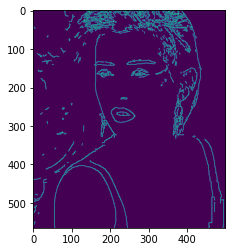

In [10]:
# 使用Canny获取图像边缘，并用不同大小threshod1和threshod2，观察获取到的边缘有何不同
wzx = cv2.imread("/Users/tanjun/Desktop/tanjun/opencv/wzx.jpg",cv2.IMREAD_GRAYSCALE)
r1 = cv2.Canny(wzx,128,200)
r2 = cv2.Canny(wzx,32,128)
img_show(r1)

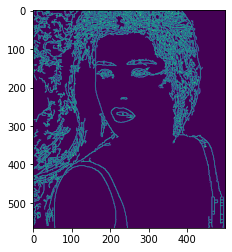

In [11]:
img_show(r2)